In [ ]:
#python 3.10.11
#tensorflow 2.10.0
#pip install numpy==1.23.5
#pip install opencv-python==4.6.0.66
#pip install matplotlib==3.5.3
#pip install scikit-learn==1.1.3
#pip install seaborn==0.12.2

In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [3]:
import os

dataset_path = r"C:\Users\ahmed\OneDrive\Desktop\Files\tasks\New folder\skin-disease-datasaet"

print("Files in dataset path:")
print(os.listdir(dataset_path))

Files in dataset path:
['test_set', 'train_set']


In [4]:
# Define paths for the train and test sets
train_path = os.path.join(dataset_path, "train_set")
test_path = os.path.join(dataset_path, "test_set")

# List contents of the train and test sets
print("Files in train set:")
print(os.listdir(train_path))


Files in train set:
['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'Normal', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles']


In [5]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [6]:
def preprocess_image(img):
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))  # Resize to 299x299
    img = img.astype('float32')
    img = preprocess_input(img)
    return img

In [7]:
# Load and preprocess data
def load_data(data_path):
    data = []
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)
            img = preprocess_image(img)  # Apply preprocessing to each image
            data.append((img, folder))
    return data

train_data = load_data(train_path)
test_data = load_data(test_path)

In [8]:
# Prepare training and validation sets
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*test_data)

X_train = np.array(X_train)
X_val = np.array(X_val)

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes=9)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=9)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [10]:
from tensorflow.keras.layers import BatchNormalization
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers[:-10]:  # Fine-tune more layers
    layer.trainable = False
class CustomBatchNormalization(BatchNormalization):
    def get_config(self):
        config = super().get_config()
        config['axis'] = -1  # Explicitly set axis as an integer
        return config

# Replace BatchNormalization in the model with CustomBatchNormalization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    CustomBatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])


In [ ]:
import tensorflow as tf
# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
y_train_one_hot = y_train_one_hot.astype('float32')
y_val_one_hot = y_val_one_hot.astype('float32')

In [13]:
for i in range(5):
    sample_batch, sample_labels = next(datagen.flow(X_train, y_train_one_hot, batch_size=32))
    print(f"Batch {i+1} - Sample batch shape: {sample_batch.shape}, Sample labels shape: {sample_labels.shape}")

Batch 1 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 9)
Batch 2 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 9)
Batch 3 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 9)
Batch 4 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 9)
Batch 5 - Sample batch shape: (32, 299, 299, 3), Sample labels shape: (32, 9)


In [14]:
history = model.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
36/36 [==============================] - 273s 7s/step - loss: 1.8210 - accuracy: 0.4470 - val_loss: 0.9821 - val_accuracy: 0.7106 - lr: 1.0000e-04
Epoch 2/50
36/36 [==============================] - 251s 7s/step - loss: 0.6541 - accuracy: 0.7791 - val_loss: 0.5772 - val_accuracy: 0.8585 - lr: 1.0000e-04
Epoch 3/50
36/36 [==============================] - 244s 7s/step - loss: 0.4437 - accuracy: 0.8545 - val_loss: 0.3892 - val_accuracy: 0.9035 - lr: 1.0000e-04
Epoch 4/50
36/36 [==============================] - 242s 7s/step - loss: 0.3227 - accuracy: 0.8948 - val_loss: 0.3346 - val_accuracy: 0.9100 - lr: 1.0000e-04
Epoch 5/50
36/36 [==============================] - 172s 5s/step - loss: 0.2443 - accuracy: 0.9308 - val_loss: 0.2695 - val_accuracy: 0.9164 - lr: 1.0000e-04
Epoch 6/50
36/36 [==============================] - 180s 5s/step - loss: 0.1963 - accuracy: 0.9465 - val_loss: 0.2399 - val_accuracy: 0.9389 - lr: 1.0000e-04
Epoch 7/50
36/36 [==============================] - 

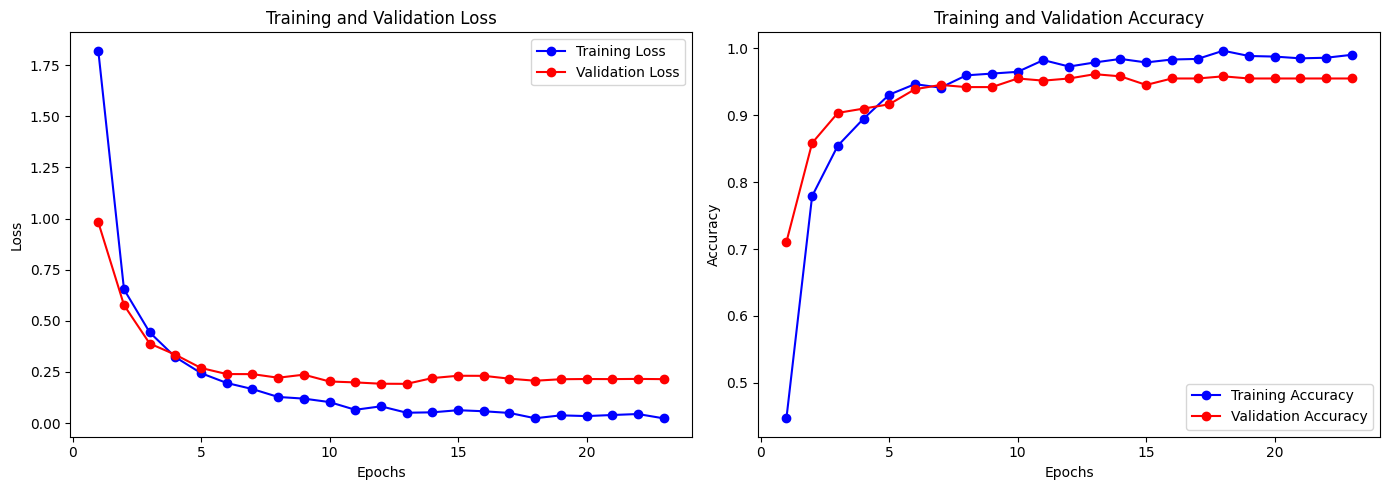

In [15]:
# Extract training and validation loss for visualization
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [16]:
# Prediction and evaluation on test set
from sklearn.metrics import classification_report
real_label = []
predicted_class = []
false_predictions = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)

        # Apply preprocessing for prediction
        img = preprocess_image(img)  # Preprocess without adding the batch dimension here
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Make prediction
        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_label = le.classes_[predicted_class_index]
        predicted_class.append(predicted_label)

        # Check if prediction is incorrect
        if predicted_label != folder:
            false_predictions.append((file_path, folder, predicted_label))




1/1 [==============================] - 0s 152ms/step


In [17]:
# Print classification report
print(classification_report(real_label, predicted_class, target_names=le.classes_))

                            precision    recall  f1-score   support

            BA- cellulitis       0.79      0.97      0.87        34
               BA-impetigo       0.91      1.00      0.95        20
           FU-athlete-foot       0.97      0.97      0.97        32
            FU-nail-fungus       1.00      1.00      1.00        33
               FU-ringworm       1.00      0.91      0.95        23
                    Normal       1.00      0.91      0.95        77
PA-cutaneous-larva-migrans       1.00      0.96      0.98        25
             VI-chickenpox       1.00      1.00      1.00        34
               VI-shingles       1.00      1.00      1.00        33

                  accuracy                           0.96       311
                 macro avg       0.96      0.97      0.96       311
              weighted avg       0.97      0.96      0.96       311



In [20]:
pip install seaborn==0.12.2

Note: you may need to restart the kernel to use updated packages.Collecting seaborn==0.12.2
     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     ---- ---------------------------------- 30.7/293.3 kB 1.3 MB/s eta 0:00:01
     ---------- -------------------------- 81.9/293.3 kB 919.0 kB/s eta 0:00:01
     ------------ -------------------------- 92.2/293.3 kB 1.1 MB/s eta 0:00:01
     ----------------------- -------------- 184.3/293.3 kB 1.1 MB/s eta 0:00:01
     ---------------------------------- --- 266.2/293.3 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
     ---------------------------------------- 0.1/11.6 MB 2.6 MB/s eta 0:00:05
      --------------------------------------- 0.2/11.6 MB 2.1 MB/s eta 0:00:06
      --------------------------------------- 0.3/11.6 MB 2.4 MB/s eta 0:00:05
     - -------------------------------------- 


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


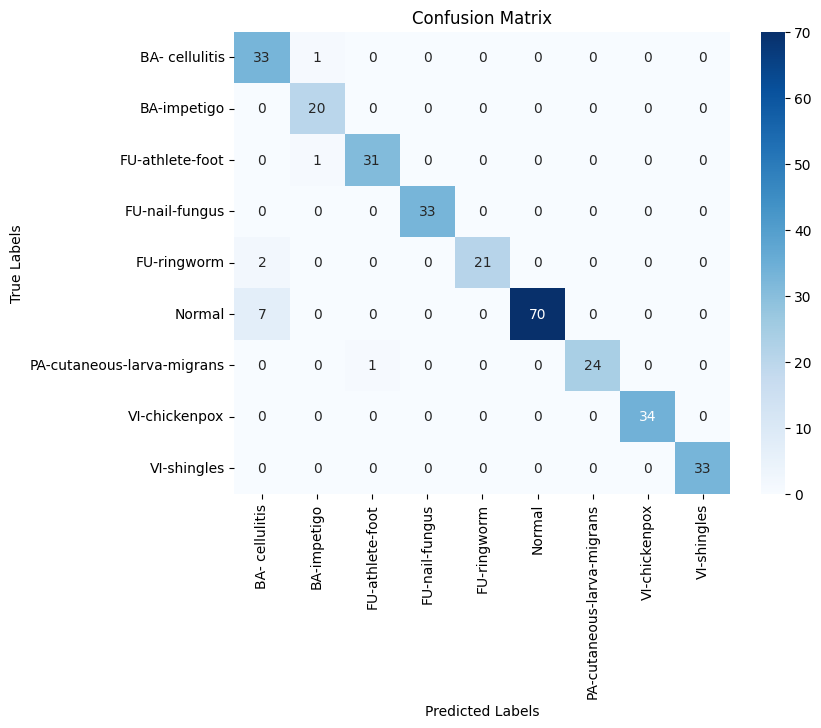

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# حساب الـ Confusion Matrix
cm = confusion_matrix(real_label, predicted_class)

# رسمها باستخدام seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Save the model in .h5 format
model.save('Skin.h5')
print("Model saved as 'Skin.h5'")

Model saved as 'Skin.h5'
